# Data-preprocessing

In [127]:
from google.colab import drive
drive.flush_and_unmount()

In [128]:
# mount the Google Drive 
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [129]:
import imageio
import os
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time

In [130]:
#let us list all the files in the image directory
path = "/content/drive/MyDrive/DSA4212/img_celeba_small/"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)


Number of images: 20000


In [131]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd

onp.random.seed(4212)

# Data Dowload
1. Download the "celeba_small.zip" file available on lumiNUS.
This is a 146Mo large zip-file containing 20K face images.
2. Download the attribute file "celeba.csv" available on lumiNUS.
3. Unzip the file "celeba_small.zip" in the directory of your choice. (Data = 175 Mo when uncompressed). 


# Brief Data exploration

In [132]:
#load attributes csv file
path_csv  = "/content/drive/MyDrive/DSA4212/"
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))


In [133]:
#"attribute" is a dictionary containing several attributes for each image
attribute.keys()

Index(['Filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [134]:
#let us list all the files in the image directory
path = "/content/drive/MyDrive/DSA4212/img_celeba_small/"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000




# General Remarks

Your assignment consists in building an algorithm that can automatically tell whether an image corresponds to a Male or Female. 

1. You are only allowed to use (variants of) logistic regression models (possibly with regularization + feature engineering). In othe words, do not use deep-learning / convolutional-layers / etc.., that is not the purpose of this assignment
2. You can only use the first 15,000 images to train your models (note that you do not have to use all the 15,000 first images if you do not want to). The accuracy of your model will be evaluated on the last 5,000 images. The last 5,000 images constitute the test set.
3. You are allowed to use whatever optimization algorithm you think is most efficient.
4. You are allowed to do whatever pre-processing and feature engineering you deem appropriate.
5. You will report the accuracy (i.e. th percentage of correctly classified) on the test dataset (i.e. the last 5,000 images). 
6. You will as well report the Area Under the Curve (AUC) of your classifier on the test dataset.


# Specific Tasks
1. How does the accuracy (ie. tested on the last 5,000 images) depend on the size of the training set? Is it necessary to use all the training set, or does the accuracy stabilize before?
2. How does the accuracy depend on the resolution of the input image?
3. Is it necessary to use colored images (or black & white images are enough)? Is it helpful to increase the contrast of the images? Other preprocessing ideas?
4. What if one only uses the area around the eyes? Around the mouth? The hair? The ears? Etc..(Jingwen)
5. Is it useful to use an ensemble of models (eg. for example, you can use a different model for each part of the face, and then try to find a way to ensemble these models)?(Guangyu)
6. Report the error rate and AUC of your best model (when evaluated on the last 5,000 images)
7. Suppose now that you can only use 1% of the data, i.e. only the first 200 images, to train your model. What is the best model you can come up with? Is it helpful to use data-augmentation strategies? Is it helpful to use regularization strategies? Ensembling? Report the error rate and AUC of your best model (when evaluated on the last 5,000 images).(Qiting)


# Last Remark
A. Your code needs to be readable and **reproducible**. Make sure that it is possible to run the notebook to reproduce all the results presented in the pdf report. 
B. You need to submit two files: (1) a jupyter notebook with your code (2) a pdf report explaining your approaches and conclusions.  
C. Your report pdf report does not need to be long. It needs to describe the experiments that you have carried out, briefly detail the algorithms that you have used, include a few figures and outline the conclusions of your investigations. You can have a look at these (very good) machine-learning papers available [here](https://nips.cc/Conferences/2021/DatasetsBenchmarks/AcceptedPapers) although (indeed!) your report definitely does not need to be as long as these articles.  
D. You need to acknowledge carefully all the sources that you have used. 

# Logistic Regression b&w

In [ ]:
train_img_array = onp.zeros((15000, 100,100))
for k in range(15000): 
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float) 
    im = resize(im, (100,100) )
    im = onp.mean(im, axis=2)   
    train_img_array[k,:,:] = im
test_img_array = onp.zeros((5000, 100,100))   
for l in range(15000,20000): 
    im2 = imageio.imread(os.path.join(path, all_img[l])).astype(float)  
    im2 = resize(im2, (100,100) ) 
    im2 = onp.mean(im2, axis=2) 
    test_img_array[l-15000,:,:] = im2


In [ ]:
y_train=[]
for k in range(15000):
   y_train.insert(k,attribute["Male"][k])
y_train=np.asarray(y_train)

In [ ]:
y_test=[]
for l in range(15000,20000):
  y_test.insert(l,attribute["Male"][l])
y_test=np.asarray(y_test)

In [ ]:
number_of_train = train_img_array.shape[0]
x_train_flatten = train_img_array.reshape(number_of_train,train_img_array.shape[1]*train_img_array.shape[2])

In [ ]:
number_of_test = test_img_array.shape[0]
x_test_flatten = test_img_array.reshape(number_of_test,test_img_array.shape[1]*test_img_array.shape[2])

In [ ]:
x_train = x_train_flatten
x_test = x_test_flatten
y_test = y_test.T
y_train = y_train.T

In [ ]:
x_train_flatten.shape

(15000, 10000)

In [ ]:
y_train.shape

(15000,)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(fit_intercept = False, C = 1e12, max_iter = 5000)

In [ ]:
model_log = logreg.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

In [ ]:
y_train_pred = logreg.predict(x_train)
y_test_pred = logreg.predict(x_test)
print("====================Train=============================")
mnb_score = accuracy_score(y_train, y_train_pred)
auc_score = roc_auc_score(y_train,y_train_pred)
print(mnb_score, auc_score)
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print("====================Test=============================")
mnb_score = accuracy_score(y_test, y_test_pred)
auc_score = roc_auc_score(y_test,y_test_pred)
print(mnb_score, auc_score)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

====================Train=============================
0.9276666666666666 0.9249430672165407
              precision    recall  f1-score   support

          -1       0.93      0.94      0.94      8668
           1       0.92      0.91      0.91      6332

    accuracy                           0.93     15000
   macro avg       0.93      0.92      0.93     15000
weighted avg       0.93      0.93      0.93     15000

[[8169  499]
 [ 586 5746]]
====================Test=============================
0.9026 0.8980193454015872
              precision    recall  f1-score   support

          -1       0.91      0.93      0.92      2901
           1       0.90      0.87      0.88      2099

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

[[2688  213]
 [ 274 1825]]


# Logistic regression with varying training size

In [ ]:
x_train_full = onp.zeros((15000, 100, 100))
for k in range(15000): 
  im = imageio.imread(os.path.join(path, all_img[k])).astype(float) 
  im = resize(im, (100,100) )
  im = onp.mean(im, axis=2)   
  x_train_full[k,:,:] = im

x_test_full = onp.zeros((5000, 100,100))   
for l in range(15000,20000): 
  im2 = imageio.imread(os.path.join(path, all_img[l])).astype(float)  
  im2 = resize(im2, (100,100) ) 
  im2 = onp.mean(im2, axis=2) 
  x_test_full[l-15000,:,:] = im2

y_train_full=[]
for k in range(15000):
  y_train_full.insert(k,attribute["Male"][k])
y_train_full = np.asarray(y_train_full)

y_test_full=[]
for l in range(15000,20000):
  y_test_full.insert(l,attribute["Male"][l])
y_test_full = np.asarray(y_test_full)

In [ ]:
def logreg_train(size = 15000, x_ = x_train_full, y_ = y_train_full,  x_test_ = x_test_full, y_test_ = y_test_full): 
  y_train_= y_train_full[:size]

  x_train_ = x_[:size]
  number_of_train = x_train_.shape[0]
  x_train_flatten = x_train_.reshape(number_of_train,x_train_.shape[1]*x_train_.shape[2])
  
  number_of_test = x_test_.shape[0]
  x_test_flatten = x_test_.reshape(number_of_test,x_test_.shape[1]*x_test_.shape[2])
  x_train = x_train_flatten
  x_test = x_test_flatten
  y_test_ = y_test_full.T
  y_train_ = y_train_.T
  
  logregg = LogisticRegression(fit_intercept = False, C = 1, max_iter = 5000, solver = 'liblinear')
  
  model_log = logregg.fit(x_train, y_train_)
  y_test_pred = logregg.predict(x_test)
  accuracy = accuracy_score(y_test_, y_test_pred)
  return accuracy

In [ ]:
train_sizes = list(range(1000, 15001, 1000))

In [ ]:
accuracy = []
for i in train_sizes:
  accuracy.append(logreg_train(size = i))

(1000, 100, 100) (1000,)
1000
(2000, 100, 100) (2000,)
2000
(3000, 100, 100) (3000,)
3000
(4000, 100, 100) (4000,)
4000
(5000, 100, 100) (5000,)
5000
(6000, 100, 100) (6000,)
6000
(7000, 100, 100) (7000,)
7000
(8000, 100, 100) (8000,)
8000
(9000, 100, 100) (9000,)
9000
(10000, 100, 100) (10000,)
10000
(11000, 100, 100) (11000,)
11000
(12000, 100, 100) (12000,)
12000
(13000, 100, 100) (13000,)
13000
(14000, 100, 100) (14000,)
14000
(15000, 100, 100) (15000,)
15000


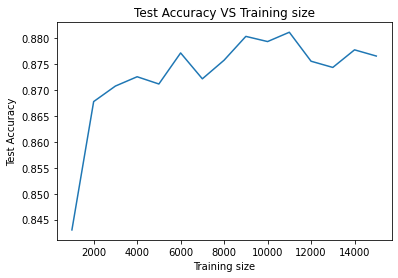

In [ ]:
plt.plot(train_sizes,accuracy)
plt.title('Test Accuracy VS Training size')
plt.xlabel('Training size')
plt.ylabel('Test Accuracy')
#plt.ylim([0.8,0.9])
plt.show()

# Logreg with varying resolution

In [ ]:
#first 6000 train, last 2k train
train_img_array = onp.zeros((6000, 100,100))
for k in range(6000): 
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float) 
    im = resize(im, (100,100) )
    im = onp.mean(im, axis=2)   
    train_img_array[k,:,:] = im
test_img_array = onp.zeros((2000, 100,100))   
for l in range(18000,20000): 
    im2 = imageio.imread(os.path.join(path, all_img[l])).astype(float)  
    im2 = resize(im2, (100,100) ) 
    im2 = onp.mean(im2, axis=2) 
    test_img_array[l-18000,:,:] = im2


In [ ]:
y_train=[]
for k in range(6000):
   y_train.insert(k,attribute["Male"][k])
y_train=np.asarray(y_train)

y_test=[]
for l in range(18000,20000):
  y_test.insert(l,attribute["Male"][l])
y_test=np.asarray(y_test)

In [ ]:
def logreg_train_res(y_ = y_train, y_test_ = y_test, resolution = 100): #y values are the same
  
  x_train_ = onp.zeros((6000, resolution,resolution))
  for k in range(6000): 
      im = imageio.imread(os.path.join(path, all_img[k])).astype(float) 
      im = resize(im, (resolution,resolution) )
      im = onp.mean(im, axis=2)   
      x_train_[k,:,:] = im
  
  x_test_ = onp.zeros((2000, resolution,resolution))   
  for l in range(18000,20000): 
      im2 = imageio.imread(os.path.join(path, all_img[l])).astype(float)  
      im2 = resize(im2, (resolution,resolution) ) 
      im2 = onp.mean(im2, axis=2) 
      x_test_[l-18000,:,:] = im2

  number_of_train = x_train_.shape[0]
  x_train_flatten = x_train_.reshape(number_of_train,x_train_.shape[1]*x_train_.shape[2])
  
  number_of_test = x_test_.shape[0]
  x_test_flatten = x_test_.reshape(number_of_test,x_test_.shape[1]*x_test_.shape[2])
  x_train = x_train_flatten
  x_test = x_test_flatten
  y_test_ = y_test_.T
  y_train_ = y_.T
  
  logregg = LogisticRegression(fit_intercept = False, C = 1, max_iter = 5000, solver = 'liblinear')
  
  model_log = logregg.fit(x_train, y_train_)
  y_test_pred = logregg.predict(x_test)
  accuracy = accuracy_score(y_test_, y_test_pred)
  return accuracy

In [ ]:
resolution = list(range(25, 178, 25))
acc = []

In [ ]:
for i in resolution:
  acc.append(logreg_train_res(resolution = i))

(6000, 25, 25) (6000,)
(6000, 50, 50) (6000,)
(6000, 75, 75) (6000,)
(6000, 100, 100) (6000,)
(6000, 125, 125) (6000,)
(6000, 150, 150) (6000,)
(6000, 175, 175) (6000,)


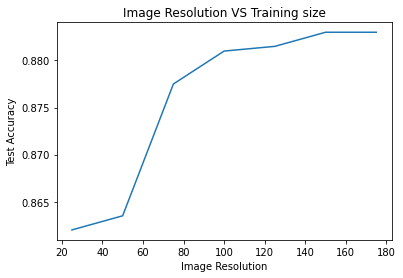

In [ ]:
plt.plot(resolution,acc)
plt.title('Image Resolution VS Training size')
plt.xlabel('Image Resolution')
plt.ylabel('Test Accuracy')
#plt.ylim([0.8,0.9])
plt.show()

# Logistic regression with 1% B&W

In [136]:
train_img_array = onp.zeros((200, 100,100))
for k in range(200): 
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float) 
    im = resize(im, (100,100) )
    im = onp.mean(im, axis=2)   
    train_img_array[k,:,:] = im
test_img_array = onp.zeros((5000, 100,100))   
for l in range(15000,20000): 
    im2 = imageio.imread(os.path.join(path, all_img[l])).astype(float)  
    im2 = resize(im2, (100,100) ) 
    im2 = onp.mean(im2, axis=2) 
    test_img_array[l-15000,:,:] = im2

In [137]:
y_train=[]
for k in range(200):
   y_train.insert(k,attribute["Male"][k])
y_train=np.asarray(y_train)

In [138]:
y_test=[]
for l in range(15000,20000):
  y_test.insert(l,attribute["Male"][l])
y_test=np.asarray(y_test)

In [139]:
number_of_train = train_img_array.shape[0]
x_train_flatten = train_img_array.reshape(number_of_train,train_img_array.shape[1]*train_img_array.shape[2])

In [140]:
number_of_test = test_img_array.shape[0]
x_test_flatten = test_img_array.reshape(number_of_test,test_img_array.shape[1]*test_img_array.shape[2])

In [141]:
x_train = x_train_flatten
x_test = x_test_flatten
y_test = y_test.T
y_train = y_train.T

In [142]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

In [143]:
logreg = LogisticRegression(C= 0.01, max_iter= 5000, solver= 'newton-cg')

In [144]:
logreg.fit(x_train, y_train)

LogisticRegression(C=0.01, max_iter=5000, solver='newton-cg')

In [145]:
y_train_pred = logreg.predict(x_train)
y_test_pred = logreg.predict(x_test)
print('---test---')
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('---train---')
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

---test---
0.7808
              precision    recall  f1-score   support

          -1       0.79      0.85      0.82      2901
           1       0.77      0.68      0.72      2099

    accuracy                           0.78      5000
   macro avg       0.78      0.77      0.77      5000
weighted avg       0.78      0.78      0.78      5000

---train---
1.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       115
           1       1.00      1.00      1.00        85

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [146]:
auc_score = roc_auc_score(y_test,y_test_pred)
auc_score

0.7675040674479515

In [147]:
print('error rate: ', 1-accuracy_score(y_test, y_test_pred))

error rate:  0.21919999999999995


# 1% b&w by area (eyes and eyebrow)

In [148]:
def predict_by_area_200(x1, x2, y1, y2):
  train_img_array = onp.zeros((200, y2-y1, x2-x1))
  for k in range(200):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = im[y1:y2,x1:x2]
    im = onp.mean(im, axis=2)
    train_img_array[k,:,:] = im

  test_img_array = onp.zeros((5000, y2-y1, x2-x1))
  for k in range(15000, 20000):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = im[y1:y2,x1:x2]
    im = onp.mean(im, axis=2)
    test_img_array[k-15000,:,:] = im

  y_train=[]
  for k in range(200):
    y_train.insert(k,attribute["Male"][k])
  y_train=np.asarray(y_train)

  y_test=[]
  for l in range(15000,20000):
    y_test.insert(l,attribute["Male"][l])
  y_test=np.asarray(y_test)

  number_of_train = train_img_array.shape[0]
  x_train_flatten = train_img_array.reshape(number_of_train,train_img_array.shape[1]*train_img_array.shape[2])

  number_of_test = test_img_array.shape[0]
  x_test_flatten = test_img_array.reshape(number_of_test,test_img_array.shape[1]*test_img_array.shape[2])
  x_train = x_train_flatten
  x_test = x_test_flatten
  y_test = y_test.T
  y_train = y_train.T

  logreg = LogisticRegression(C= 1, max_iter= 5000, solver= 'liblinear')
  logreg.fit(x_train, y_train)
  y_train_pred = logreg.predict(x_train)
  y_test_pred = logreg.predict(x_test)
  print('Training accuracy: ', accuracy_score(y_train, y_train_pred))
  print('Training AUC: ', roc_auc_score(y_train, y_train_pred))
  print(classification_report(y_train, y_train_pred))
  print('Test accuracy: ', accuracy_score(y_test, y_test_pred))
  print('Test AUC: ', roc_auc_score(y_test, y_test_pred))
  print(classification_report(y_test, y_test_pred))
  return

In [149]:
print('Eyes area')
predict_by_area_200(50,122,12,105)

Training accuracy:  1.0
Training AUC:  1.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       115
           1       1.00      1.00      1.00        85

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Test accuracy:  0.6204
Test AUC:  0.604185378076821
              precision    recall  f1-score   support

          -1       0.66      0.71      0.68      2901
           1       0.55      0.50      0.53      2099

    accuracy                           0.62      5000
   macro avg       0.61      0.60      0.60      5000
weighted avg       0.62      0.62      0.62      5000



In [163]:
print('Eyebrow area')
predict_by_area_200(50,122,95,109)

Eyebrow area
Training accuracy:  1.0
Training AUC:  1.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       115
           1       1.00      1.00      1.00        85

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Test accuracy:  0.773
Test AUC:  0.7600578499733709
              precision    recall  f1-score   support

          -1       0.78      0.84      0.81      2901
           1       0.76      0.68      0.72      2099

    accuracy                           0.77      5000
   macro avg       0.77      0.76      0.76      5000
weighted avg       0.77      0.77      0.77      5000



# 1% data with augmentation

In [164]:
im = imageio.imread(os.path.join(path, all_img[0])).astype(float)
im.shape

(218, 178, 3)

In [165]:
im = imageio.imread(os.path.join(path, all_img[0]), pilmode='RGB').astype(float)
im.shape

(218, 178, 3)

In [166]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
from keras.preprocessing.image import array_to_img

(218, 178, 1)


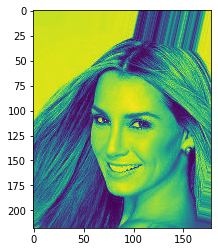

In [167]:
img = load_img(os.path.join(path, all_img[0]), color_mode='grayscale')
plt.imshow(img)
img = img_to_array(img)
print(img.shape)

(100, 100, 1)


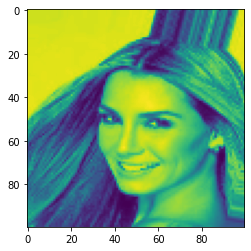

In [168]:
img = resize(img, (100, 100))
print(img.shape)
plt.imshow(array_to_img(img))

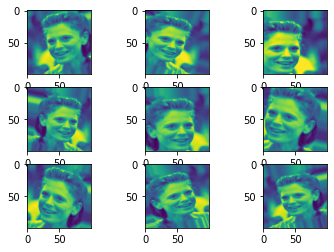

In [169]:
img = load_img(os.path.join(path, all_img[1]), color_mode='grayscale')
sample = img_to_array(img)
sample = resize(sample, (100,100) )
sample = expand_dims(sample, 0)
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, height_shift_range=0.1,
                             width_shift_range=0.2, brightness_range=(0.75,1.15),
                             zoom_range=0.2)

it = datagen.flow(sample, batch_size=1)

for i in range(9):
  plt.subplot(330 + 1 + i)
  batch = it.next()
  image = batch[0].astype('uint8')
  img_to_array(image)
  plt.imshow(array_to_img(image))
plt.show()

In [170]:
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, height_shift_range=0.1,
                             width_shift_range=0.2, brightness_range=(0.75,1.15),
                             zoom_range=0.2)

#augment each image 9 times
train_img_array = onp.zeros((2000,100,100,1))
for k in range(200): 
  im = load_img(os.path.join(path, all_img[i]),color_mode='grayscale') 
  im = img_to_array(im)
  im = resize(im, (100,100) )
  train_img_array[k*10,:,:,:] = im
  sample = expand_dims(im, 0)

  for i in range(9):
    it = datagen.flow(sample, batch_size=1)
    batch = it.next()
    image = batch[0].astype('uint8')
    image = img_to_array(image)
    train_img_array[k*10 + i + 1,:,:,:] = image


test_img_array = onp.zeros((5000,100,100,1))   
for l in range(15000,20000):
  im = load_img(os.path.join(path, all_img[l]),color_mode='grayscale') 
  im = img_to_array(im)
  im = resize(im, (100,100) )
  test_img_array[l-15000,:,:,:] = im

In [171]:
ls = [1]
ls.extend([attribute["Male"][0]]*10)
ls

[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [172]:
y_train=[]
for k in range(200):
  labels = [attribute["Male"][k]]*10
  y_train.extend(labels)
y_train = np.asarray(y_train)

In [173]:
y_train.shape

(2000,)

In [174]:
y_test=[]
for l in range(15000,20000):
  y_test.insert(l,attribute["Male"][l])
y_test=np.asarray(y_test)

In [175]:
number_of_train = train_img_array.shape[0]
x_train_flatten = train_img_array.reshape(number_of_train,train_img_array.shape[1]*train_img_array.shape[2])

In [176]:
number_of_test = test_img_array.shape[0]
x_test_flatten = test_img_array.reshape(number_of_test,test_img_array.shape[1]*test_img_array.shape[2])

In [177]:
x_train = x_train_flatten
x_test = x_test_flatten
y_test = y_test.T
y_train = y_train.T

In [178]:
x_train_flatten.shape

(2000, 10000)

In [179]:
y_train.shape

(2000,)

In [180]:
logreg = LogisticRegression(max_iter = 5000)
logreg.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

In [181]:
y_train_pred = logreg.predict(x_train)
y_test_pred = logreg.predict(x_test)
print("====================Train=============================")
mnb_score = accuracy_score(y_train, y_train_pred)
auc_score = roc_auc_score(y_train,y_train_pred)
print(mnb_score, auc_score)
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print("====================Test=============================")
mnb_score = accuracy_score(y_test, y_test_pred)
auc_score = roc_auc_score(y_test,y_test_pred)
print(mnb_score, auc_score)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

====================Train=============================
0.9575 0.95
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      1150
           1       1.00      0.90      0.95       850

    accuracy                           0.96      2000
   macro avg       0.97      0.95      0.96      2000
weighted avg       0.96      0.96      0.96      2000

[[1150    0]
 [  85  765]]
====================Test=============================
0.5672 0.5281778440809702
              precision    recall  f1-score   support

          -1       0.60      0.77      0.67      2901
           1       0.47      0.28      0.36      2099

    accuracy                           0.57      5000
   macro avg       0.54      0.53      0.52      5000
weighted avg       0.55      0.57      0.54      5000

[[2238  663]
 [1501  598]]
